# Prédiction de l'équipe gagnante

Précision du modèle : 0.46


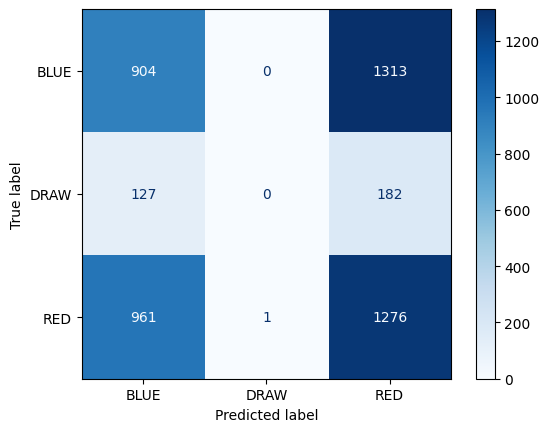

['predict_winner_model.pkl']

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# Charger les données
data = pd.read_csv("/content/dataset_Ynov_babyfoot_CLEAN (14).csv")
num_cols = ['player_goals', 'player_own_goals', 'player_assists', 'player_saves', 'player_age']
for c in num_cols:
    data[c] = pd.to_numeric(data[c], errors='coerce').fillna(0)

# Calcul des stats historiques par joueur
data['game_date'] = pd.to_datetime(data['game_date'])
data = data.sort_values(by='game_date')  # Trier par date

stats_cols = ['player_goals', 'player_own_goals', 'player_assists', 'player_saves']

for col in stats_cols:
    # cumul des stats jusqu'au match précédent
    data[f'hist_{col}'] = data.groupby('player_id')[col].cumsum() - data[col]

# Agrégation des stats historiques par équipe
agg_funcs = {
    'hist_player_goals': 'sum',
    'hist_player_own_goals': 'sum',
    'hist_player_assists': 'sum',
    'hist_player_saves': 'sum',
    'player_age': 'mean'
}

team_stats = data.groupby(['game_id', 'team_color']).agg(agg_funcs).reset_index()

# Séparer RED et BLUE
red_stats = team_stats[team_stats['team_color'] == 'RED'].add_prefix('red_')
blue_stats = team_stats[team_stats['team_color'] == 'BLUE'].add_prefix('blue_')

# Fusionner pour créer une ligne par match
match_features = pd.merge(red_stats, blue_stats, left_on='red_game_id', right_on='blue_game_id')

# Ajouter la cible (winner)
match_results = data[['game_id', 'winner']].drop_duplicates()
match_df = pd.merge(match_features, match_results, left_on='red_game_id', right_on='game_id')

# Préparer X et y
X = match_df.drop(columns=['red_game_id', 'blue_game_id', 'game_id', 'winner',
                           'red_team_color', 'blue_team_color'])
y = match_df['winner']

# Encodage de la cible
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split et entraînement du modèle
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# Évaluation
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Précision du modèle : {acc:.2f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.show()

# Sauvegarde du modèle
joblib.dump(model, "predict_winner_model.pkl")

# Test de la prédiction à partir de matchs fictifs

In [9]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder

# Supposons 2 matchs fictifs avec stats historiques des joueurs par équipe
data_test = pd.DataFrame({
    'red_hist_player_goals': [5, 2],
    'red_hist_player_own_goals': [0, 1],
    'red_hist_player_assists': [7, 3],
    'red_hist_player_saves': [4, 2],
    'red_player_age': [24, 26],

    'blue_hist_player_goals': [3, 6],
    'blue_hist_player_own_goals': [1, 0],
    'blue_hist_player_assists': [5, 6],
    'blue_hist_player_saves': [3, 5],
    'blue_player_age': [25, 23]
})

# Charger le modèle entraîné
model = joblib.load("predict_winner_model.pkl")

# Encodage pour correspondre aux labels
le = LabelEncoder()
le.fit(['RED', 'BLUE'])

# Prédiction
y_pred_test = model.predict(data_test)
pred_labels = le.inverse_transform(y_pred_test)

print("Prédictions sur le jeu de test factice :")
for i, label in enumerate(pred_labels):
    print(f"Match test {i+1}: {label}")


Prédictions sur le jeu de test factice :
Match test 1: BLUE
Match test 2: BLUE
